# Setup

In [1]:
from google.colab import drive
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Pipeline


In [4]:
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:

file_path = "/content/drive/MyDrive/24fall_dlProject/data/BTC-USD_stock_data.csv"

data = pd.read_csv(file_path,index_col='Date',parse_dates=['Date'])

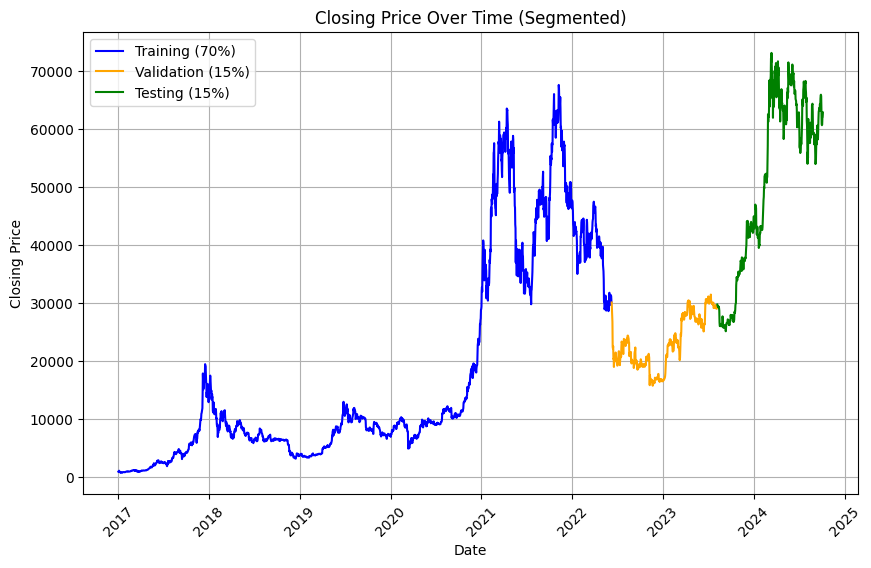

In [6]:
close_data = data['Close'].values  # Get 'Close' data as a NumPy array
total_data_points = len(close_data)
segment1_end = int(total_data_points * 0.7)
segment2_end = int(total_data_points * (0.7 + 0.15))

plt.figure(figsize=(10, 6))

# Plotting segments with different colors
plt.plot(data.index[:segment1_end], close_data[:segment1_end], label='Training (70%)', color='blue')
plt.plot(data.index[segment1_end:segment2_end], close_data[segment1_end:segment2_end], label='Validation (15%)', color='orange')
plt.plot(data.index[segment2_end:], close_data[segment2_end:], label='Testing (15%)', color='green')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price Over Time (Segmented)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [12]:
def data_preprocessing_with_closed_price_and_min_max_scaler(data, seq_length=1):
    train_ratio = 0.7
    val_ratio = 0.15
    close_data = data["Close"].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 10))
    data_scaled = scaler.fit_transform(close_data)
    data_scaled = pd.DataFrame(data_scaled, columns=["Close"])

    def create_feature_datasets(data, x_size):
        x_datasets = []
        y_datasets = []
        for i in range(len(data) - x_size):
            x = data[i:i + x_size].values.reshape(-1, 1)
            y = data[i + x_size:i + x_size + 1].values.reshape(1)
            x_datasets.append(x)
            y_datasets.append(y)
        X = np.array(x_datasets)
        y = np.array(y_datasets)
        X_train =  X[:int(len(X) * train_ratio)]
        y_train = y[:int(len(y) * train_ratio)]
        X_val = X[int(len(X) * train_ratio):int(len(X) * (train_ratio + val_ratio))]
        y_val = y[int(len(y) * train_ratio):int(len(y) * (train_ratio + val_ratio))]
        X_test = X[int(len(X) * (train_ratio + val_ratio)):]
        y_test = y[int(len(y) * (train_ratio + val_ratio)):]

        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        return torch.Tensor(X_train_shuffled).to(device), torch.Tensor(X_val).to(device), torch.Tensor(X_test).to(device), torch.Tensor(y_train_shuffled).to(device), torch.Tensor(y_val).to(device), torch.Tensor(y_test).to(device)

    return create_feature_datasets(data_scaled, seq_length), scaler

(X_train, X_val, X_test, y_train, y_val, y_test), min_max_scaler = data_preprocessing_with_closed_price_and_min_max_scaler(data, 1)

# Baseline Model

In [8]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)  # Initial hidden state
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)  # Initial cell state
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])  # Get the output from the last time step
        return out

# Training

In [9]:
# create a nn class (just-for-fun choice :-)
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

Baseline RMSE: 534.2574153355434


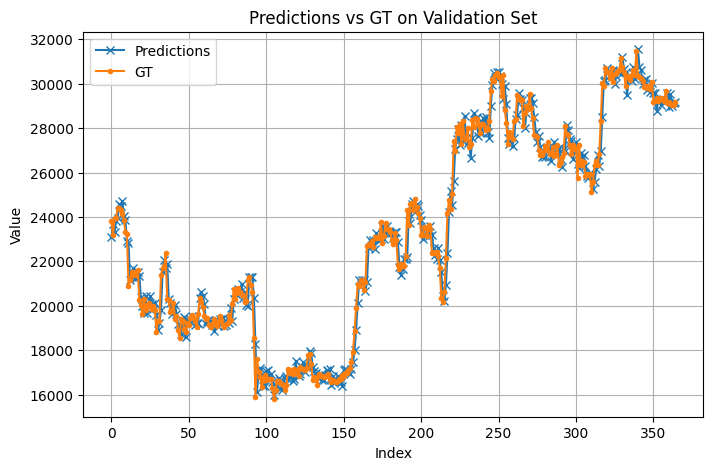

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
close_data_train = close_data[:segment1_end]
close_data_val = close_data[segment1_end:segment2_end]

seq_length = 60
X_train = []
y_train = []
for i in range(seq_length, len(close_data_val)):
    X_train.append(close_data_val[i - seq_length:i])
    y_train.append(close_data_val[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train, predictions))
print(f"Baseline RMSE: {rmse}")


plt.figure(figsize=(8, 5))
plt.plot(range(len(predictions)), predictions, label="Predictions", marker="x")
plt.plot(range(len(y_train)), y_train, label="GT", marker=".")
plt.title("Predictions vs GT on Validation Set")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# Hyperparameters
input_size = 1
hidden_size = 32
num_layers = 1
dropout = 0.2
output_size = 1
learning_rate = 0.0001
num_epochs = 200
batch_size = 128

# Create dataset and DataLoader for batching
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Model, loss, optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout)
model = model.to(device)
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch_losses = []

# Training loop with batching
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (batch_x, batch_y) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    epoch_losses.append(loss.item())
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [5/200], Loss: 2.7751
Epoch [10/200], Loss: 2.7295
Epoch [15/200], Loss: 2.6783
Epoch [20/200], Loss: 2.6203
Epoch [25/200], Loss: 2.5548
Epoch [30/200], Loss: 2.4815
Epoch [35/200], Loss: 2.4002
Epoch [40/200], Loss: 2.3111
Epoch [45/200], Loss: 2.2146
Epoch [50/200], Loss: 2.1117
Epoch [55/200], Loss: 2.0041
Epoch [60/200], Loss: 1.8938
Epoch [65/200], Loss: 1.7825
Epoch [70/200], Loss: 1.6720
Epoch [75/200], Loss: 1.5641
Epoch [80/200], Loss: 1.4598
Epoch [85/200], Loss: 1.3591
Epoch [90/200], Loss: 1.2613
Epoch [95/200], Loss: 1.1653
Epoch [100/200], Loss: 1.0702
Epoch [105/200], Loss: 0.9754
Epoch [110/200], Loss: 0.8806
Epoch [115/200], Loss: 0.7865
Epoch [120/200], Loss: 0.6942
Epoch [125/200], Loss: 0.6059
Epoch [130/200], Loss: 0.5249
Epoch [135/200], Loss: 0.4556
Epoch [140/200], Loss: 0.4020
Epoch [145/200], Loss: 0.3646
Epoch [150/200], Loss: 0.3397
Epoch [155/200], Loss: 0.3221
Epoch [160/200], Loss: 0.3081
Epoch [165/200], Loss: 0.2959
Epoch [170/200], Loss: 0.2849


# Visualization

In [53]:
model.eval()
with torch.no_grad():
    predictions = model(X_train)
    print(f'Predicted value for the first sample: {predictions[0].item():.4f}')
rmse = torch.sqrt(torch.mean((predictions - y_train) ** 2))
print(f"Training Loss Scaling Unreversed: {rmse.item()}")

if device == torch.device("cuda"):
    predictions_cpu = predictions.cpu()
    y_train_cpu = y_train.cpu()

# Reverse the scaling
predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(predictions_cpu.numpy()))
y_train_reversed = torch.Tensor(min_max_scaler.inverse_transform(y_train_cpu.numpy()))
rmse_reversed = torch.sqrt(torch.mean((predictions_reversed - y_train_reversed) ** 2))
print(f"Training Loss Scaling Reversed: {rmse_reversed.item()}")

Predicted value for the first sample: 1.3201
Training Loss Scaling Unreversed: 0.24717888236045837
Training Loss Scaling Reversed: 1787.2452392578125


In [54]:
model.eval()
with torch.no_grad():
    predictions = model(X_val)
    print(f'Predicted value for the first sample: {predictions[0].item():.4f}')
rmse = torch.sqrt(torch.mean((predictions - y_val) ** 2))
print(f"Validation Loss Scaling Unreversed: {rmse.item()}")

if device == torch.device("cuda"):
    predictions_cpu = predictions.cpu()
    y_val_cpu = y_val.cpu()

# Reverse the scaling
predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(predictions_cpu.numpy()))
y_val_reversed = torch.Tensor(min_max_scaler.inverse_transform(y_val_cpu.numpy()))
rmse_reversed = torch.sqrt(torch.mean((predictions_reversed - y_val_reversed) ** 2))
print(f"Validation Loss Scaling Reversed: {rmse_reversed.item()}")

Predicted value for the first sample: 4.3927
Validation Loss Scaling Unreversed: 0.22955317795276642
Validation Loss Scaling Reversed: 1659.8013916015625


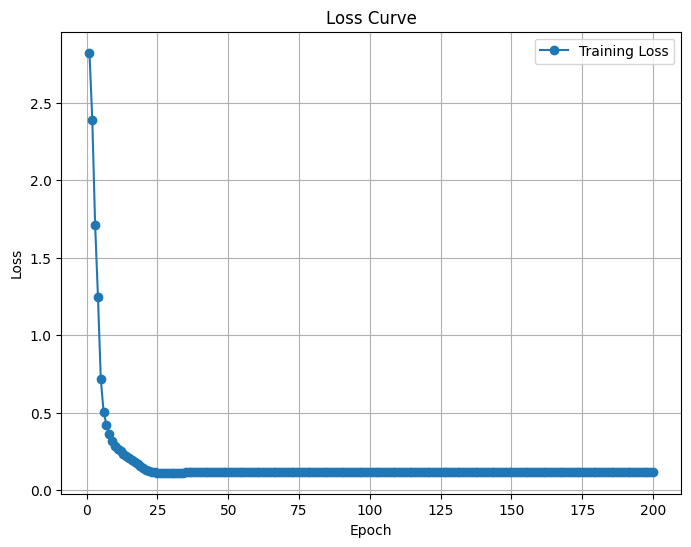

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

ValueError: x and y must be the same size

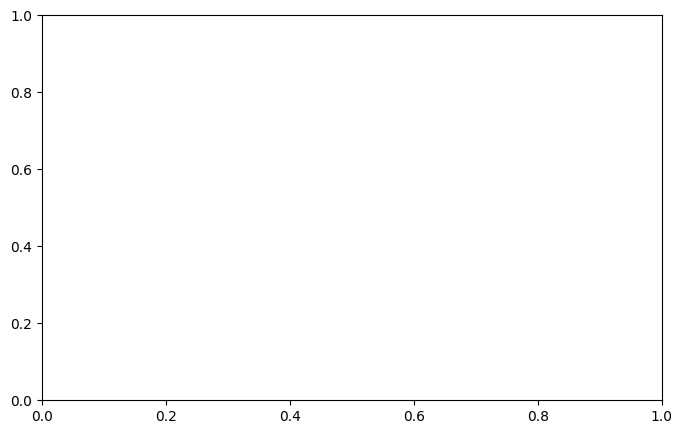

In [44]:

# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_train_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.scatter(tensor1.numpy(), tensor2.numpy(), label='Predictions vs GT', marker='o', s=10)

min_val = min(tensor1.min(), tensor2.min())
max_val = max(tensor1.max(), tensor2.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='-', label='Predictions = GT')

plt.title('Predictions vs GT on Training Set')
plt.xlabel('Predictions')
plt.ylabel('GT')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_train_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy() - tensor2.numpy(), label='Predictions - GT', marker='o')
plt.title('Differences between Predictions and GT on Training Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

ValueError: operands could not be broadcast together with shapes (425,) (1984,) 

<Figure size 800x500 with 0 Axes>

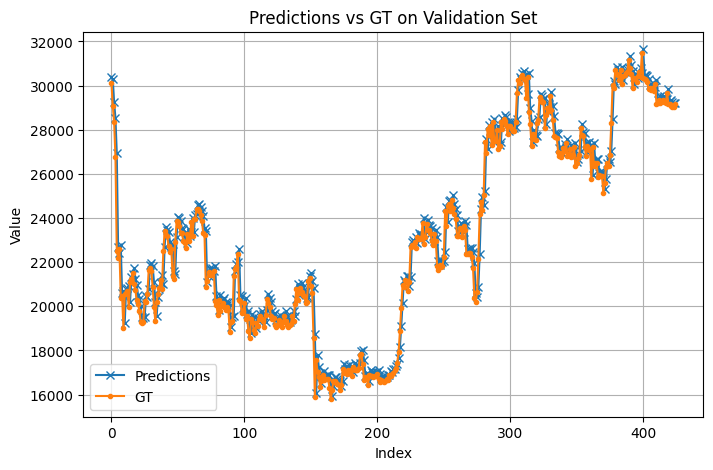

In [ ]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_val_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy(), label='Predictions', marker='x')
plt.plot(tensor2.numpy(), label='GT', marker='.')
plt.title('Predictions vs GT on Validation Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

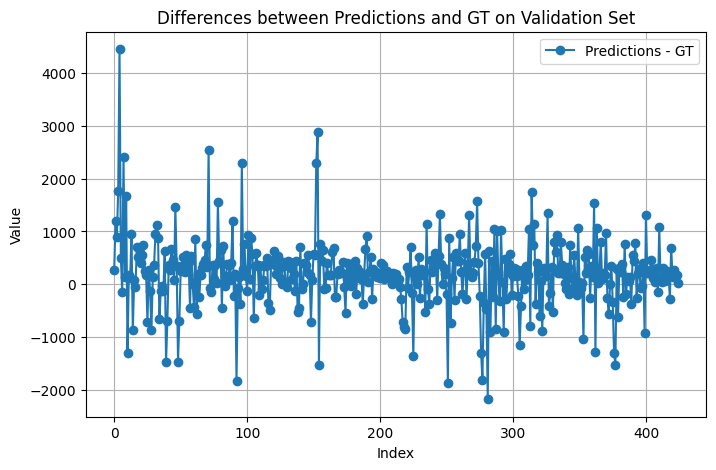

In [ ]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_val_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy() - tensor2.numpy(), label='Predictions - GT', marker='o')
plt.title('Differences between Predictions and GT on Validation Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Return

In [ ]:
def calculate_daily_long_trade_return_percentage(predicted_prices, true_prices):
  def generate_daily_trade_signals_long_only(predicted_prices, true_prices):
    signals = torch.zeros_like(predicted_prices)
    signals[:-1] = torch.where(predicted_prices[1:] > predicted_prices[:-1], 1, 0)  # Buy if tomorrow's predicted price > today's
    return signals

  signals = generate_daily_trade_signals_long_only(predicted_prices, true_prices)

  # Calculate price differences and percentage change
  price_diff = true_prices[1:] - true_prices[:-1]
  percentage_returns = (price_diff / true_prices[:-1])  # Convert to percentage change
  # Calculate returns based on signals
  returns = signals[:-1] * percentage_returns

  # Step 1: Calculate cumulative returns
  cumulative_returns = torch.cumprod(1 + returns, dim=0)

  # Step 2: Calculate running maximum of cumulative returns
  running_max, _ = torch.cummax(cumulative_returns, dim=0)

  # Step 3: Calculate drawdowns
  drawdowns = (cumulative_returns - running_max) / running_max

  # Step 4: Find the maximum drawdown
  max_drawdown = drawdowns.min()

  print("Return:", cumulative_returns[-1].item() - 1)
  print("Max Drawdown:", max_drawdown.item())

In [ ]:
# Example usage:
predicted_prices = predictions_reversed.view(-1)
true_prices = y_val_reversed.view(-1)

calculate_daily_long_trade_return_percentage(predicted_prices, true_prices)

Return: 0.19343459606170654
Max Drawdown: -0.18859362602233887


In [ ]:
def calculate_daily_short_trade_return_percentage(predicted_prices, true_prices):
  def generate_daily_trade_signals_short_only(predicted_prices, true_prices):
    signals = torch.zeros_like(predicted_prices)
    # Generate a short signal (-1) if tomorrow's predicted price is lower than today's predicted price
    signals[:-1] = torch.where(predicted_prices[1:] < predicted_prices[:-1], 1, 0)
    return signals

  signals = generate_daily_trade_signals_short_only(predicted_prices, true_prices)

  # Calculate price differences and percentage change
  price_diff = true_prices[:-1] - true_prices[1:]  # Since this is a short trade, we reverse the diff
  percentage_returns = (price_diff / true_prices[:-1])  # Convert to percentage change
  # Calculate returns based on signals
  returns = signals[:-1] * percentage_returns
  # Step 1: Calculate cumulative returns
  cumulative_returns = torch.cumprod(1 + returns, dim=0)

  # Step 2: Calculate running maximum of cumulative returns
  running_max, _ = torch.cummax(cumulative_returns, dim=0)

  # Step 3: Calculate drawdowns
  drawdowns = (cumulative_returns - running_max) / running_max

  # Step 4: Find the maximum drawdown
  max_drawdown = drawdowns.min()

  print("Return:", cumulative_returns[-1].item() - 1)
  print("Max Drawdown:", max_drawdown.item())

In [ ]:
# Example usage:
predicted_prices = predictions_reversed.view(-1)
true_prices = y_val_reversed.view(-1)

calculate_daily_short_trade_return_percentage(predicted_prices, true_prices)

Return: 0.029468774795532227
Max Drawdown: -0.31678810715675354


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/24fall_dlProject/pretrained_model/decoder_model.pth')